In [161]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet

In [162]:
def get_untrained_net(training_dict,data_settings):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device", flush=True)

    # Abstraction system
    num_abs_agents = training_dict['model_paras']['M']
    abs_action_space_dim =  training_dict['model_paras']['L']  # number of discrete abstract actions
    # abstract action policy network parameters
    hidden_capacity = training_dict['model_paras']['hidden_capacity']
    enc_hidden_dim = int(hidden_capacity/num_abs_agents)
    action_space_dim = 2
    state_space_dim = data_settings['sys_parameters']['K']
    num_agents = data_settings['sys_parameters']['N']
    # Initialize abstraction system model
    net = STOMPnet(
                state_space_dim,
                abs_action_space_dim,
                enc_hidden_dim,
                num_agents,
                num_abs_agents,
                action_space_dim=action_space_dim
            )
    net.to(device)
    state_dict=net.state_dict()
    print(f"has {sum(p.numel() for p in state_dict.values())} parameters")
    return net
    
from torch import nn
import itertools

def get_probs_on_vertices_from_model(net,data_settings):
    net.eval()
    with torch.no_grad():
        vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=data_settings['sys_parameters']['K'])))
        logit_arrays=net(vertex_states)
        f=nn.Softmax(dim=-1)
        return np.array(f(logit_arrays))

In [452]:
data_settings_str =\
                '_4agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_1.0' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_1' +\
                '_K_10' +\
                '_N_4' +\
                '_T_10000' +\
                f'_g_9.0'
print(data_settings_str)
seed_idx = 0
#  '_singletask_baseline' +\
#                 '_multitask_baseline' +\
training_settings_str =\
                '_STOMPnet_M_2_L_4_nfeatures_2' +\
                '_cap_240' +\
                '_trainseed_0' +\
                '_epochs_100' +\
                '_batchsz_16' +\
                '_lr_0.001'
print(training_settings_str)

_4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2_simulationdata_actsel_greedy_numepi_1_K_10_N_4_T_10000_g_9.0
_STOMPnet_M_2_L_4_nfeatures_2_cap_240_trainseed_0_epochs_100_batchsz_16_lr_0.001


In [456]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()

data_root = out_dir + data_settings_str + f"_dataseed_{seed_idx}"
training_data = np.load(data_root+".npy", allow_pickle=True).item()
training_dict = np.load(data_root + training_settings_str + ".npy", allow_pickle=True).item()
trained_model_state_dict = torch.load(data_root + training_settings_str+ '_state_dict.pt')
import json
print('data_settings')
print(json.dumps(data_settings,sort_keys=True, indent=4))
print('\ntraining_data')
for key in trained_model_state_dict.keys():
    print(key)
print(json.dumps(training_dict,sort_keys=True, indent=4))
print(f"\nmodel has {sum(p.numel() for p in trained_model_state_dict.values())} parameters grouped as:")

data_settings
{
    "actsel": "greedy",
    "dataset_label": "4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2",
    "episode_length": 10000,
    "num_episodes": 1,
    "num_seeds": 2,
    "sys_parameters": {
        "K": 10,
        "N": 4,
        "action_space_dim": 2,
        "fluctuation_strength_factor": 9.0,
        "jointagent_groundmodel_paras": {
            "M": 2,
            "corr": 1.0,
            "ensemble": "sum",
            "modelname": "bitpop"
        }
    }
}

training_data
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.weight
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.bias
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.weight
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.bias
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.weight
sample_from_abstract_joint_policy.abstract_agent_po

## Loss and action probabilities

In [433]:
def plot_loss(model_name):
    training_settings_str =\
                '_'+model_name +\
                '_cap_240' +\
                '_trainseed_0' +\
                '_epochs_100' +\
                '_batchsz_16' +\
                '_lr_0.001'
    out_dir = "output/"
#     data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
    data_root = out_dir + data_settings_str + f"_dataseed_{seed_idx}"
#     training_data = np.load(data_root+".npy", allow_pickle=True).item()
    training_dict = np.load(data_root + training_settings_str + ".npy", allow_pickle=True).item()
#     trained_model_state_dict = torch.load(data_root + training_settings_str+ '_state_dict.pt')
    
    return training_dict['training_data']['loss'],training_dict['training_data']['accuracy']

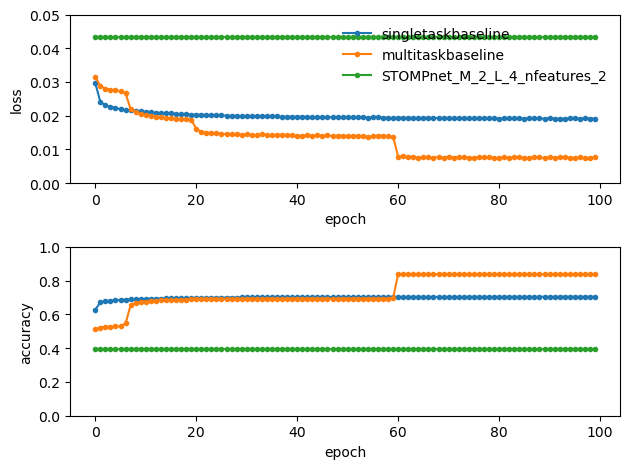

In [440]:
fig,ax=pl.subplots(2,1)
for model_name in ['singletaskbaseline','multitaskbaseline','STOMPnet_M_2_L_4_nfeatures_2']:
    loss,accuracy=plot_loss(model_name)
    ax[0].plot(loss,'.-',label=model_name)
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylim(0,0.05)
    ax[0].legend(frameon=False)
    
    ax[1].plot(accuracy,'.-',label=model_name)
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylim(0,1)
    
#     acc == (true == mdl(x).max(1).item() / true.size(0)
fig.tight_layout()

In [441]:
net = get_untrained_net(training_dict,data_settings)
prelearning_probs=get_probs_on_vertices_from_model(net,data_settings)

Using cpu device
has 260866 parameters


In [442]:
net = get_untrained_net(training_dict,data_settings)
untrained_net_paras=net.state_dict()

Using cpu device
has 260866 parameters


In [443]:
from torch.nn import functional as F

In [444]:
untrained_assignment_probs = F.softmax(untrained_net_paras['assigner.abs_agent_assignment_embedding.weight'],dim=1)
trained_assignment_probs = F.softmax(trained_model_state_dict['assigner.abs_agent_assignment_embedding.weight'],dim=1)
print(untrained_assignment_probs)
print(trained_assignment_probs)
print(trained_assignment_probs-untrained_assignment_probs)

tensor([[0.2697, 0.7303],
        [0.2158, 0.7842],
        [0.3450, 0.6550],
        [0.3298, 0.6702]])
tensor([[0.8038, 0.1962],
        [0.3550, 0.6450],
        [0.3211, 0.6789],
        [0.7077, 0.2923]])
tensor([[ 0.5341, -0.5341],
        [ 0.1392, -0.1392],
        [-0.0238,  0.0238],
        [ 0.3779, -0.3779]])


Does assigner learn to group 1st 2 and last two agents. Test: 

In [457]:
num_abs_agents = 2
probs=np.array([np.mean(np.array(trained_assignment_probs[:(num_agents/num_abs_agents),0])),
                np.mean(np.array(trained_assignment_probs[(num_agents/num_abs_agents):,0]))])
assigner_loss=np.min((np.linalg.norm(np.array([0,1])-probs),np.linalg.norm(np.array([1,0])-probs)))
assigner_loss

0.6644652518369977

In [446]:
prelearning_probs=get_probs_on_vertices_from_model(net,data_settings)
net.load_state_dict(trained_model_state_dict)
postlearning_probs=get_probs_on_vertices_from_model(net,data_settings)

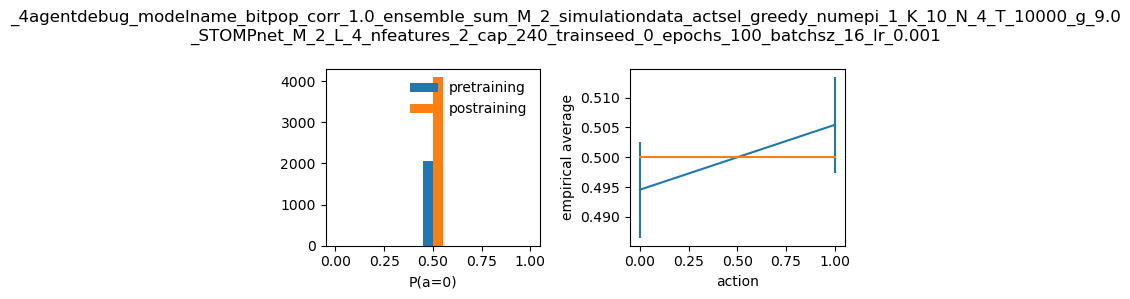

In [447]:
fig,ax = pl.subplots(1,2,figsize=(6,3))
ax[0].hist(prelearning_probs[:,:,0].flatten(),bins=np.linspace(0,1,21),label="pretraining")
ax[0].hist(postlearning_probs[:,:,0].flatten(),bins=np.linspace(0,1,21),label='postraining')
ax[0].set_xlabel('P(a=0)')
ax[0].legend(frameon=False)
ax[1].errorbar(x=range(len(prelearning_probs[0,0,:])),y=np.mean(prelearning_probs,axis=(0,1)),yerr=np.std(prelearning_probs,axis=(0,1)),label='pretraining')
ax[1].errorbar(x=range(len(postlearning_probs[0,0,:])),y=np.mean(postlearning_probs,axis=(0,1)),yerr=np.std(postlearning_probs,axis=(0,1)),label='posttraining')
ax[1].set_xlabel('action')
ax[1].set_ylabel('empirical average')
fig.suptitle(data_settings_str+'\n'+training_settings_str)
fig.tight_layout()

### Dataset analysis

In [391]:
def get_data(g):
    data_settings_str =\
                '_4agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_1.0' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_1' +\
                '_K_10' +\
                '_N_4' +\
                '_T_10000' +\
                f'_g_'+g+'.0'
    seed_idx = 0
    out_dir = "output/"
    data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
    epi_dims = [data_settings['num_episodes'],data_settings['episode_length']]
    data_root = out_dir + data_settings_str + f"_dataseed_{seed_idx}"
    training_data = np.load(data_root+".npy", allow_pickle=True).item()
    states=training_data["states"].reshape(tuple(epi_dims+[data_settings['sys_parameters']['K']]))
    actions=training_data["actions"].reshape(tuple(epi_dims+[data_settings['sys_parameters']['N']]))
    episode_times=training_data["times"].reshape(tuple(epi_dims+[1]))
    return states,actions, episode_times

In [357]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
    fig,ax=pl.subplots()
    ax.plot(states[epi_idx,:100,0])
    ax.plot(states[epi_idx,:100,1])
#     ax.set_ylim(-10,10)
# pl.gca().set_yscale('loout_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3042940992.py, line 1)

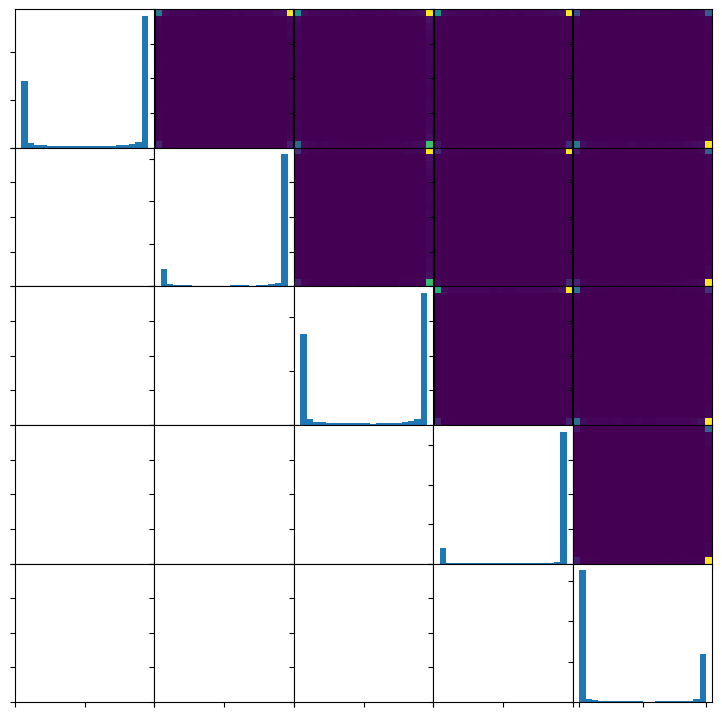

In [451]:
Kmax=5#states.shape[1]
fig,ax=pl.subplots(Kmax,Kmax,figsize=(9,9))
for rit in range(Kmax):
    for cit in range(Kmax):
        if rit==cit:
            ax[rit,cit].hist(states[0,:,rit],bins=20)
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[0,:,rit], states[0,:,cit], bins=20)
#             extent = [0, 1, 0, 1]
            extent = [-1, 1, -1, 1]
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)

In [348]:
orthant_index_seq=np.array([np.sum(np.power(2,np.arange(states.shape[2]))[state>0]) for state in states[0,:,:]])

In [ ]:
import matplotlib

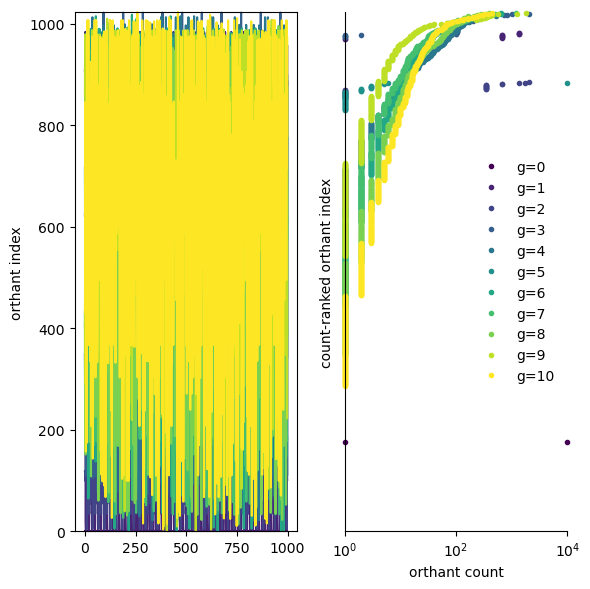

In [459]:
fig,ax=pl.subplots(1,2,figsize=(6,6))
gvec=np.arange(11)
colors=pl.cm.get_cmap('viridis')(np.linspace(0, 1, len(gvec)))
store_states=[]
for git,g in enumerate(gvec):
    states,actions,epi_times=get_data(str(g))
    store_states.append(states[0,:,:])
    orthant_index_seq=np.array([np.sum(np.power(2,np.arange(states.shape[2]))[state>0]) for state in states[0,:,:]])
    counts,bins=np.histogram(orthant_index_seq,bins=range(max(orthant_index_seq)+1));
    sorted_inds=np.argsort(counts)
    counts=counts[sorted_inds]

    ax[0].plot(orthant_index_seq[:1000],'-',clip_on=False,color=colors[git])
    ax[0].set_ylim(0,max(orthant_index_seq))
    ax[0].set_ylabel('orthant index')

    non_zero_counts=counts>0
    ax[1].plot(counts[non_zero_counts],bins[:-1][non_zero_counts],'.',color=colors[git],label="g="+str(g),clip_on=False)
    ax[1].set_yticks([])
    ax[1].set_xlabel('orthant count')
    ax[1].set_ylabel('count-ranked orthant index')
    ax[1].set_xscale('log')
    ax[1].set_ylim(0,max(orthant_index_seq)+1)
    ax[1].set_xlim(1,10000)
    ax[1].spines[['right', 'top']].set_visible(False)
    ax[1].legend(frameon=False)
    fig.tight_layout()
# ax[1].hist(orthant_index_seq,bins=np.arange(max(orthant_index_seq)),orientation="horizontal")

In [448]:
orthant_index_seq=np.array([np.sum(np.power(2,np.arange(states.shape[2]))[state>0]) for state in states.reshape((-1,data_settings['sys_parameters']['K']))])

In [449]:
values,counts=np.unique(orthant_index_seq,return_counts=True)

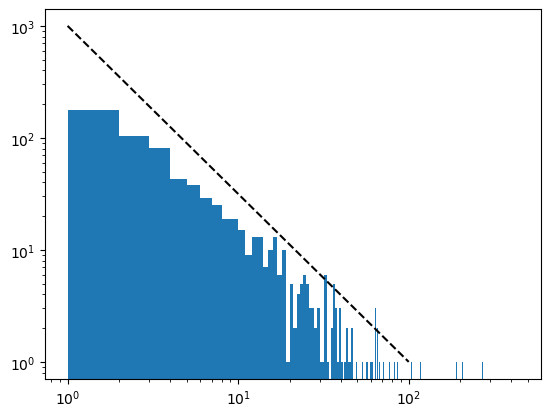

In [450]:
pl.hist(counts,bins=range(max(counts)+1));
pl.gca().set_yscale('log')
pl.gca().set_xscale('log')
pl.plot(np.arange(1,101),1000*np.arange(1,101)**(-3/2),'k--')

In [191]:
# plot binned states
df = pd.DataFrame(states, columns=range(states.shape[1]))
binned_df=(df>0.5)
outdf=binned_df.groupby(binned_df.columns.tolist(),as_index=False).size()#/len(df)
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant sample size')
ax.set_yscale('log')

ValueError: Must pass 2-d input. shape=(100, 100, 15)

## Untested

In [14]:
def get_probs_on_vertices_from_data(states,actions):
    vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=len(states[0]))))
    states=states>0.5
    actions_on_vertices=-np.ones((vertex_states.shape[0],actions.shape[1]))
    got_list=[]
    for i,binarized_state in enumerate(states[:20000]): 
        for j,vertex_state in enumerate(vertex_states):
            if np.all(binarized_state == vertex_state):
                actions_on_vertices[j]=actions[i]
                break
        if np.mod(i,100)==0:
            print(np.sum(actions_on_vertices==-1))
    return actions_on_vertices

In [15]:
 data_actions=get_probs_on_vertices_from_data(states,actions)

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [16]:
data_actions=data_actions[data_actions[:,0]!=-1]

/home/mptouzel/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


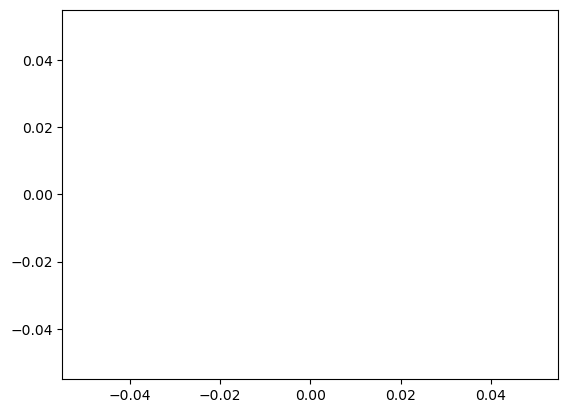

In [17]:
fig,ax=pl.subplots()
ax.plot(np.mean(data_actions,axis=0))

In [ ]:
from utils import get_corr_matrix
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_xticks(range(num_agents))
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

In [ ]:
from utils import compare_plot
fig=compare_plot([outdir+data_filename])
fig.savefig(f'{data_filename[:-4]}_summary_fig.pdf', transparent=True, bbox_inches="tight", dpi=300)


In [ ]:
df = pd.DataFrame(states, columns=range(states.shape[1]))
axis_array=pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(9,9));
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit!=cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=50)
            extent = [0, 1, 0, 1]
#             axis.remove()
            axis.imshow(heatmap.T, extent=extent, origin='lower')

In [ ]:
fig,ax=pl.subplots(*axis_array.shape,figsize=(9,9))
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
#             axis.remove()
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

In [ ]:
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant visitation frequency')
ax.set_yscale('log')